In [68]:
!pip install snowflake

Fetching data for SUZLON (SUZLON.NS)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to stock_data_colab/suzlon_last_30_days.csv

Fetching data for PATEL_ENG (PATELENG.NS)...
Saved data to stock_data_colab/patel_eng_last_30_days.csv

Fetching data for MAZDOG (MAZDOCK.NS)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved data to stock_data_colab/mazdog_last_30_days.csv

Fetching data for HUDKO (HUDCO.NS)...
Saved data to stock_data_colab/hudko_last_30_days.csv

Fetching data for BSE (BSE.NS)...


[*********************100%***********************]  1 of 1 completed

Saved data to stock_data_colab/BSE_last_30_days.csv



In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
import os

In [ ]:
stock_list = {
    "suzlon": "SUZLON.NS",
    "patel_eng": "PATELENG.NS",
    "mazdog": "MAZDOCK.NS",
    "hudko": "HUDCO.NS",
    "BSE": "BSE.NS"
}

output_dir = 'stock_data_colab'
os.makedirs(output_dir, exist_ok=True)

for name, ticker in stock_list.items():
    print(f"Fetching data for {name.upper()} ({ticker})...")

    data = yf.download(ticker, period="30d", interval="1d")

    filename = f"{output_dir}/{name}_last_30_days.csv"
    data.to_csv(filename)

    print(f"Saved data to {filename}\n")

In [72]:
import pandas as pd
import os
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

# Path to the folder containing CSV files
folder_path = "/content/stock_data_colab"

# Snowflake connection parameters
user = 'DARSHIT012'
password = 'Darshit@123459876'
account = 'DRLDKJR-YV03536'
warehouse = 'COMPUTE_WH'
database = 'STOCK_ANALYSIS'
schema = 'PUBLIC'

# Create Snowflake SQLAlchemy engine
engine = create_engine(URL(
    user=user,
    password=password,
    account=account,
    warehouse=warehouse,
    database=database,
    schema=schema
))

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        table_name = os.path.splitext(filename)[0].upper()

        try:
            df = pd.read_csv(file_path)
            df.to_sql(table_name, engine, index=False, if_exists='replace')
            print(f"✅ Uploaded {filename} to table `{table_name}`")
        except Exception as e:
            print(f"Table already exist {filename}")


Table already exist mazdog_last_30_days.csv
Table already exist suzlon_last_30_days.csv
Table already exist BSE_last_30_days.csv
Table already exist patel_eng_last_30_days.csv
Table already exist IDIA_last_30_days.csv
Table already exist hudko_last_30_days.csv
Table already exist zometo_last_30_days.csv


In [80]:
# data.index = pd.to_datetime(data.index)

In [81]:
# !pip install snowflake-connector-python pandas sqlalchemy

import pandas as pd
import snowflake.connector
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Snowflake configuration
snowflake_config = {
    'user': 'DARSHIT012',
    'password': 'Darshit@123459876',
    'account': 'DRLDKJR-YV03536',
    'warehouse': 'COMPUTE_WH',
    'database': 'STOCK_ANALYSIS',
    'schema': 'PUBLIC'
}

def connect_to_snowflake(config):
    try:
        conn = snowflake.connector.connect(**config)
        print("✅ Connected to Snowflake successfully!")
        return conn
    except Exception as e:
        print(f" Connection failed: {e}")
        return None

def list_all_tables(conn):
    try:
        cursor = conn.cursor()
        cursor.execute("SHOW TABLES")
        tables = cursor.fetchall()

        print("📊 Available tables in STOCK_ANALYSIS database:")
        print("-" * 50)
        for table in tables:
            table_name = table[1]
            print(f"• {table_name}")

        cursor.close()
        return [table[1] for table in tables]
    except Exception as e:
        print(f"❌ Error listing tables: {e}")
        return []

def read_table_info(conn, table_name):
    try:
        cursor = conn.cursor()

        # Get row count
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        row_count = cursor.fetchone()[0]

        # Get column info
        cursor.execute(f"DESCRIBE TABLE {table_name}")
        columns = cursor.fetchall()

        print(f"\n📋 Table: {table_name}")
        print(f"   Rows: {row_count:,}")
        print(f"   Columns: {len(columns)}")
        print("   Column Details:")
        for col in columns:
            print(f"     - {col[0]} ({col[1]})")

        cursor.close()
        return row_count, columns
    except Exception as e:
        print(f"❌ Error getting table info for {table_name}: {e}")
        return None, None

def read_snowflake_table(conn, table_name, limit=None):
    try:
        if limit:
            query = f"SELECT * FROM {table_name} LIMIT {limit}"
        else:
            query = f"SELECT * FROM {table_name}"

        df = pd.read_sql(query, conn)
        print(f"✅ Successfully loaded {len(df)} rows from {table_name}")
        return df
    except Exception as e:
        print(f"❌ Error reading table {table_name}: {e}")
        return None

def explore_table_data(df, table_name):
    """Basic exploration of the DataFrame"""
    print(f"\n🔍 Data Exploration for {table_name}:")
    print("-" * 50)
    print(f"Shape: {df.shape}")
    print(f"Data Types:\n{df.dtypes}")
    print(f"\nFirst 5 rows:")
    print(df.head())

conn = connect_to_snowflake(snowflake_config)

if conn:
    tables = list_all_tables(conn)

    dataframes = {}

    print("\n" + "="*60)
    print("📊 LOADING ALL TABLES")
    print("="*60)

    for table_name in tables:
        print(f"\n🔄 Processing {table_name}...")

        row_count, columns = read_table_info(conn, table_name)

        df = read_snowflake_table(conn, table_name)

        if df is not None:
            clean_name = table_name.lower().replace('_', '_')
            dataframes[clean_name] = df

            # Basic exploration
            explore_table_data(df, table_name)

            print(f"✅ {table_name} loaded successfully!")

        print("-" * 60)

    conn.close()
    print("\n" + "="*60)
    print(f"Total tables loaded: {len(dataframes)}")
    print("\nDataFrame variables created:")
    for name, df in dataframes.items():
        print(f"• {name}: {df.shape[0]} rows × {df.shape[1]} columns")

    print("\n💡 How to use your data:")
    print("# Access individual DataFrames:")
    for name in dataframes.keys():
        print(f"# {name}_df = dataframes['{name}']")

    print("\n🎯 Creating individual DataFrame variables...")
    for name, df in dataframes.items():
        globals()[f"{name}_df"] = df
        print(f"✅ {name}_df created")

else:
    print("❌ Could not establish connection to Snowflake")

=== Snowflake Data Reader for Google Colab ===

✅ Connected to Snowflake successfully!
📊 Available tables in STOCK_ANALYSIS database:
--------------------------------------------------
• BSE_LAST_30_DAYS
• HUDKO_LAST_30_DAYS
• IDIA_LAST_30_DAYS
• MAZDOG_LAST_30_DAYS
• PATEL_ENG_LAST_30_DAYS
• SUZLON_LAST_30_DAYS
• ZOMETO_LAST_30_DAYS

📊 LOADING ALL TABLES

🔄 Processing BSE_LAST_30_DAYS...

📋 Table: BSE_LAST_30_DAYS
   Rows: 32
   Columns: 6
   Column Details:
     - Price (VARCHAR(16777216))
     - Close (VARCHAR(16777216))
     - High (VARCHAR(16777216))
     - Low (VARCHAR(16777216))
     - Open (VARCHAR(16777216))
     - Volume (VARCHAR(16777216))
✅ Successfully loaded 32 rows from BSE_LAST_30_DAYS

🔍 Data Exploration for BSE_LAST_30_DAYS:
--------------------------------------------------
Shape: (32, 6)
Data Types:
Price     object
Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object

First 5 rows:
        Price              Close      

In [99]:
# print(hudko_last_30_days_df)

In [ ]:
# import os

# output_dir = 'stock_data_csvs'
# os.makedirs(output_dir, exist_ok=True)

# for name, df in dataframes.items():
#     filename = f"{output_dir}/{name}.csv"
#     df.to_csv(filename, index=True)

# print("CSV files saved successfully in the Colab environment.")

CSV files saved successfully in the Colab environment.


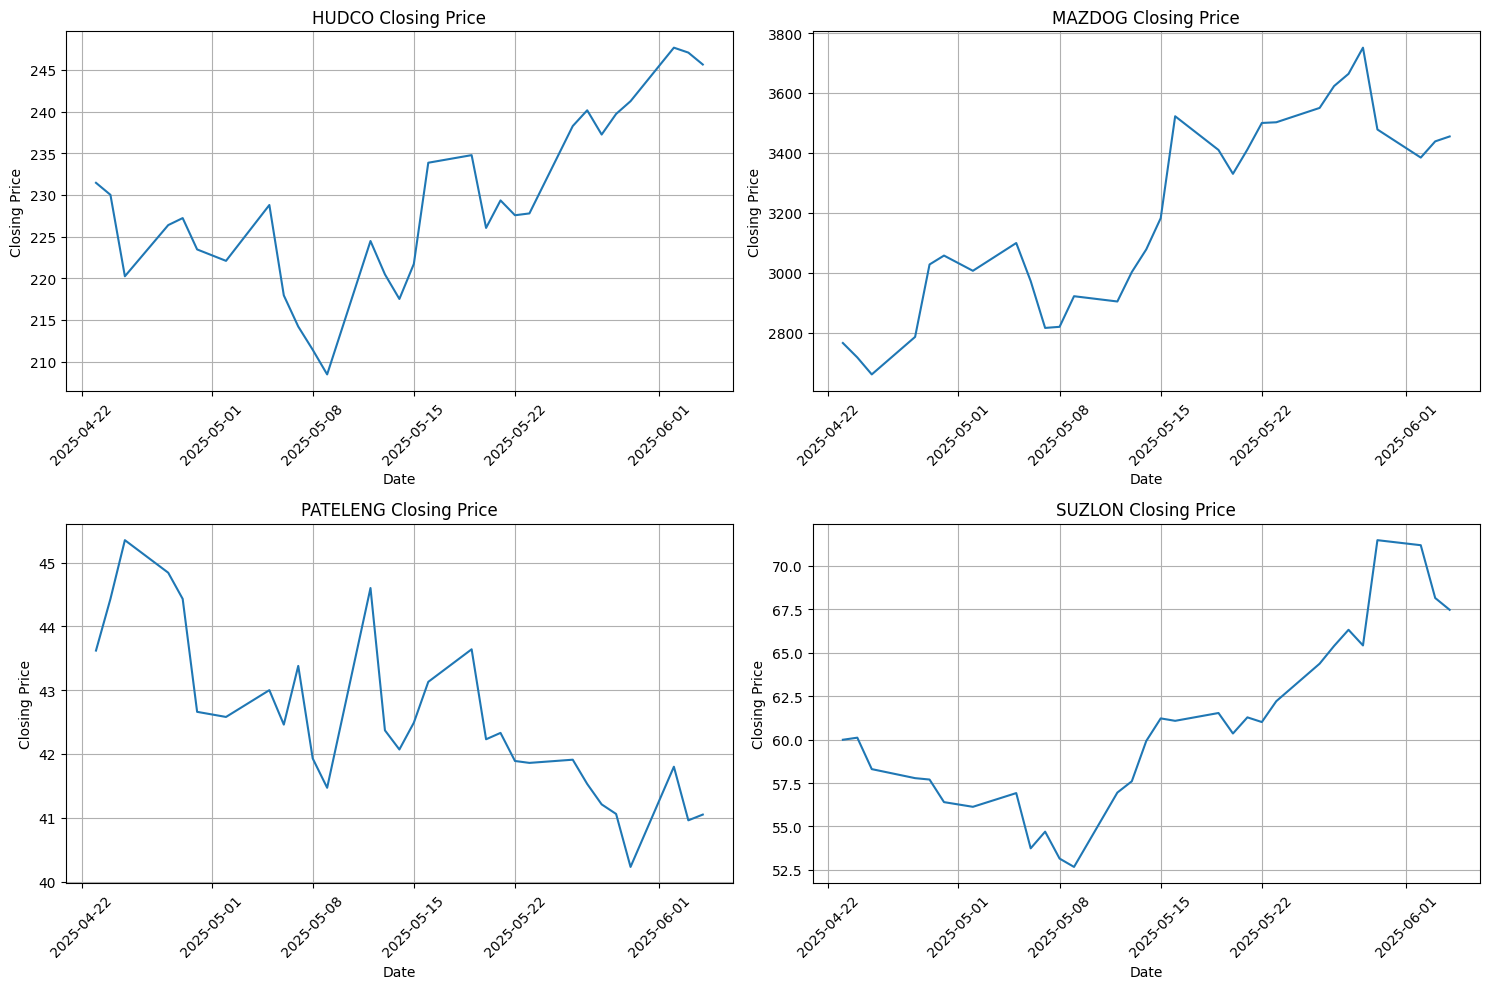

In [84]:
import matplotlib.pyplot as plt
import pandas as pd # Import pandas as it's used for data manipulation

stock_dataframes_subset = {
    'HUDCO': hudko_last_30_days_df,
    'MAZDOG': mazdog_last_30_days_df,
    'PATELENG': patel_eng_last_30_days_df,
    'SUZLON': suzlon_last_30_days_df
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes to easily iterate

for i, (name, df) in enumerate(stock_dataframes_subset.items()):
    # Check if DataFrame is not empty and has enough rows after removing metadata
    if not df.empty and df.shape[0] > 2: # Skip the first two rows based on the provided data snippet
        # Clean and prepare the data: skip first 2 rows and use 'Price' as date column
        plot_df = df.iloc[2:].copy() # Skip the first two rows
        plot_df['Price'] = pd.to_datetime(plot_df['Price'])
        plot_df.set_index('Price', inplace=True)
        plot_df['Close'] = pd.to_numeric(plot_df['Close'], errors='coerce') # Use errors='coerce' for robustness

        # Create the plot
        axes[i].plot(plot_df.index, plot_df['Close'])
        axes[i].set_title(f'{name} Closing Price')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Closing Price')
        axes[i].grid(True)
        axes[i].tick_params(axis='x', rotation=45) # Rotate x-axis labels
    else:
        print(f"DataFrame for {name} is empty or has insufficient data after removing metadata, skipping plot.")


plt.tight_layout()
plt.show()

In [86]:
for name, df in processed_stock_data.items():
    df['Change_Type'] = df['Price_Change'].apply(lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'No Change'))
    display(f"{name} Data with Change Type:")
    display(df.head())

'HUDCO Data with Change Type:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type
Price,,,,,,,
2025-04-23,231.449997,238.300003,224.350006,235.000000,12653711,-3.550003,Bearish
2025-04-24,230.009995,234.500000,229.000000,231.199997,5796226,-1.190002,Bearish
2025-04-25,220.240005,231.699997,219.000000,230.440002,7566520,-10.199997,Bearish
2025-04-28,226.380005,227.770004,219.000000,219.000000,5644189,7.380005,Bullish
2025-04-29,227.220001,230.699997,226.500000,227.000000,3872551,0.220001,Bullish


'MAZDOG Data with Change Type:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type
Price,,,,,,,
2025-04-23,2765.899902,2829.000000,2713.199951,2780.000000,2256385,-14.100098,Bearish
2025-04-24,2717.699951,2850.000000,2704.100098,2778.000000,3144655,-60.300049,Bearish
2025-04-25,2661.100098,2745.699951,2585.000000,2727.000000,3521060,-65.899902,Bearish
2025-04-28,2786.300049,2815.000000,2646.100098,2649.899902,5345902,136.400146,Bullish
2025-04-29,3027.899902,3048.300049,2817.899902,2817.899902,13653093,210.000000,Bullish


'PATELENG Data with Change Type:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type
Price,,,,,,,
2025-04-23,43.619999,44.220001,42.520000,43.900002,3004150,-0.280003,Bearish
2025-04-24,44.430000,44.950001,43.439999,43.700001,4133073,0.730000,Bullish
2025-04-25,45.349998,48.599998,44.250000,47.240002,21015525,-1.890003,Bearish
2025-04-28,44.840000,46.139999,44.369999,46.000000,5949113,-1.160000,Bearish
2025-04-29,44.430000,45.700001,43.060001,45.000000,3442736,-0.570000,Bearish


'SUZLON Data with Change Type:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type
Price,,,,,,,
2025-04-23,59.990002,60.169998,58.130001,59.680000,97968387,0.310001,Bullish
2025-04-24,60.110001,61.490002,59.720001,60.000000,97850644,0.110001,Bullish
2025-04-25,58.299999,60.450001,56.720001,60.310001,104362729,-2.010002,Bearish
2025-04-28,57.779999,58.490002,57.000000,57.500000,50641247,0.279999,Bullish
2025-04-29,57.700001,59.500000,57.349998,58.000000,51629064,-0.299999,Bearish


In [87]:
change_type_counts = {}

for name, df in processed_stock_data.items():
    counts = df['Change_Type'].value_counts().to_dict()
    change_type_counts[name] = counts

for name, counts in change_type_counts.items():
    display(f"{name} Change Type Counts:")
    display(counts)

'HUDCO Change Type Counts:'

{'Bearish': 16, 'Bullish': 14}

'MAZDOG Change Type Counts:'

{'Bearish': 15, 'Bullish': 15}

'PATELENG Change Type Counts:'

{'Bearish': 18, 'Bullish': 12}

'SUZLON Change Type Counts:'

{'Bullish': 17, 'Bearish': 13}

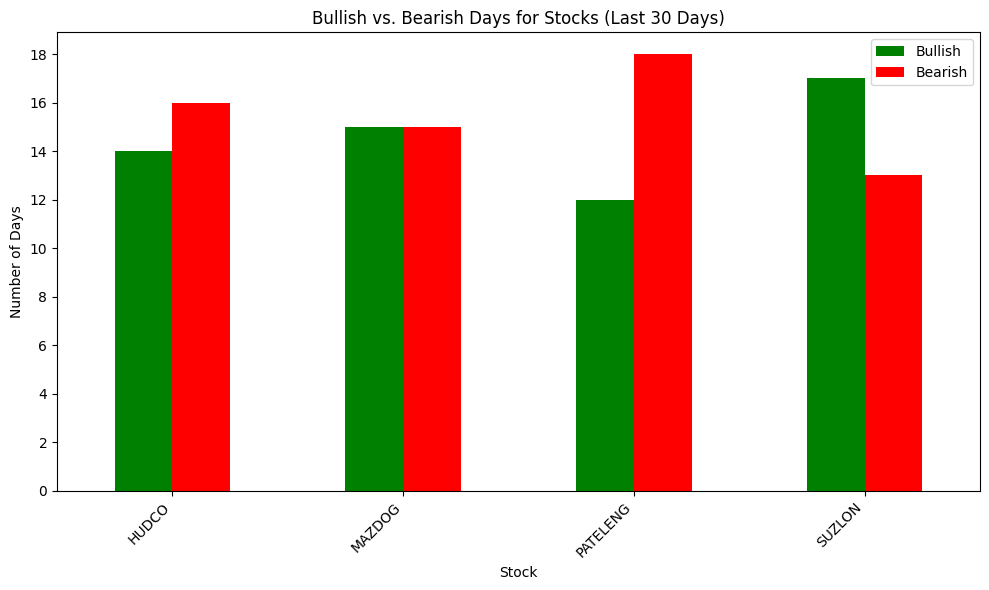

In [103]:
change_type_df = pd.DataFrame(change_type_counts).T

if not change_type_df.empty:
    ax = change_type_df[['Bullish', 'Bearish']].plot(kind='bar', color=['green', 'red'], figsize=(10, 6))
    plt.title('Bullish vs. Bearish Days for Stocks (Last 30 Days)')
    plt.xlabel('Stock')
    plt.ylabel('Number of Days')
    plt.xticks(rotation=45, ha='right')

    max_days = change_type_df[['Bullish', 'Bearish']].values.max()
    if max_days == 0:
        max_days = 1
    ax.set_yticks(np.arange(0, max_days + 1, 2))

    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot Bullish vs. Bearish days.")

In [90]:
for name, df in processed_stock_data.items():
    # Calculate Daily Percentage Change
    df['Daily_%_Change'] = ((df['Close'] - df['Open']) / df['Open']) * 100
    display(f"{name} Data with Daily % Change:")
    display(df.head())

'HUDCO Data with Daily % Change:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type,Daily_%_Change
Price,,,,,,,,
2025-04-23,231.449997,238.300003,224.350006,235.000000,12653711,-3.550003,Bearish,-1.510640
2025-04-24,230.009995,234.500000,229.000000,231.199997,5796226,-1.190002,Bearish,-0.514707
2025-04-25,220.240005,231.699997,219.000000,230.440002,7566520,-10.199997,Bearish,-4.426314
2025-04-28,226.380005,227.770004,219.000000,219.000000,5644189,7.380005,Bullish,3.369865
2025-04-29,227.220001,230.699997,226.500000,227.000000,3872551,0.220001,Bullish,0.096917


'MAZDOG Data with Daily % Change:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type,Daily_%_Change
Price,,,,,,,,
2025-04-23,2765.899902,2829.000000,2713.199951,2780.000000,2256385,-14.100098,Bearish,-0.507198
2025-04-24,2717.699951,2850.000000,2704.100098,2778.000000,3144655,-60.300049,Bearish,-2.170628
2025-04-25,2661.100098,2745.699951,2585.000000,2727.000000,3521060,-65.899902,Bearish,-2.416571
2025-04-28,2786.300049,2815.000000,2646.100098,2649.899902,5345902,136.400146,Bullish,5.147370
2025-04-29,3027.899902,3048.300049,2817.899902,2817.899902,13653093,210.000000,Bullish,7.452358


'PATELENG Data with Daily % Change:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type,Daily_%_Change
Price,,,,,,,,
2025-04-23,43.619999,44.220001,42.520000,43.900002,3004150,-0.280003,Bearish,-0.637819
2025-04-24,44.430000,44.950001,43.439999,43.700001,4133073,0.730000,Bullish,1.670479
2025-04-25,45.349998,48.599998,44.250000,47.240002,21015525,-1.890003,Bearish,-4.000853
2025-04-28,44.840000,46.139999,44.369999,46.000000,5949113,-1.160000,Bearish,-2.521739
2025-04-29,44.430000,45.700001,43.060001,45.000000,3442736,-0.570000,Bearish,-1.266666


'SUZLON Data with Daily % Change:'

,Close,High,Low,Open,Volume,Price_Change,Change_Type,Daily_%_Change
Price,,,,,,,,
2025-04-23,59.990002,60.169998,58.130001,59.680000,97968387,0.310001,Bullish,0.519439
2025-04-24,60.110001,61.490002,59.720001,60.000000,97850644,0.110001,Bullish,0.183334
2025-04-25,58.299999,60.450001,56.720001,60.310001,104362729,-2.010002,Bearish,-3.332784
2025-04-28,57.779999,58.490002,57.000000,57.500000,50641247,0.279999,Bullish,0.486954
2025-04-29,57.700001,59.500000,57.349998,58.000000,51629064,-0.299999,Bearish,-0.517240


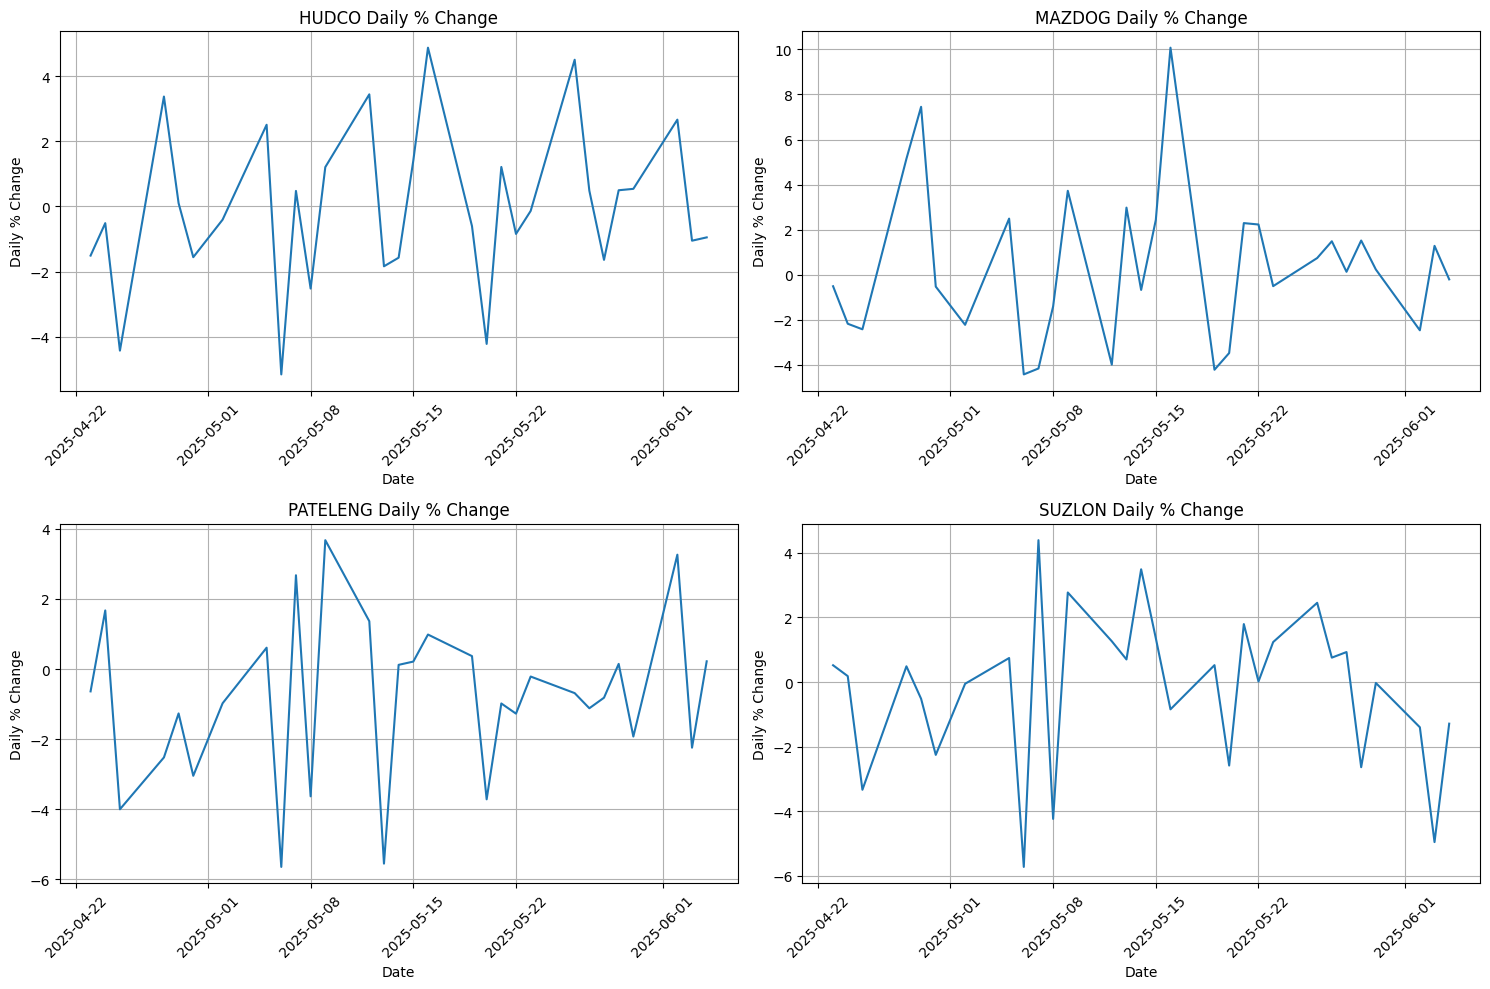

In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, df) in enumerate(processed_stock_data.items()):
    # Create the plot for Daily % Change
    axes[i].plot(df.index, df['Daily_%_Change'])
    axes[i].set_title(f'{name} Daily % Change')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Daily % Change')
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

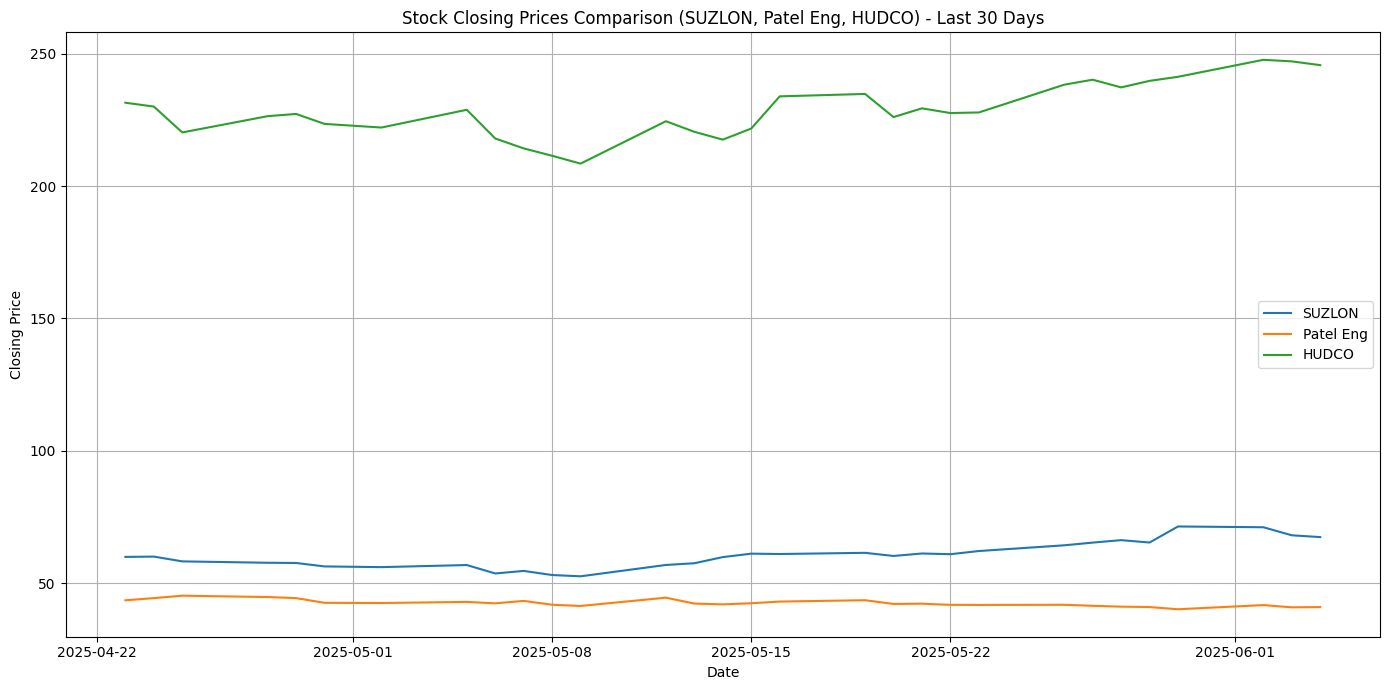

In [93]:
import matplotlib.pyplot as plt

# Select the closing price data for the specified stocks from the processed dataframes
suzlon_close = processed_stock_data['SUZLON']['Close']
patel_eng_close = processed_stock_data['PATELENG']['Close']
hudco_close = processed_stock_data['HUDCO']['Close']


# Combine the closing prices into a single DataFrame
combined_close_prices_subset = pd.DataFrame({
    'SUZLON': suzlon_close,
    'PATELENG': patel_eng_close,
    'HUDCO': hudco_close
})

# Create the line plot
plt.figure(figsize=(14, 7))
plt.plot(combined_close_prices_subset.index, combined_close_prices_subset['SUZLON'], label='SUZLON')
plt.plot(combined_close_prices_subset.index, combined_close_prices_subset['PATELENG'], label='Patel Eng')
plt.plot(combined_close_prices_subset.index, combined_close_prices_subset['HUDCO'], label='HUDCO')


plt.title('Stock Closing Prices Comparison (SUZLON, Patel Eng, HUDCO) - Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt # Import matplotlib for subplot functionality

stock_dataframes_subset = {
    'HUDCO': hudko_last_30_days_df,
    'MAZDOG': mazdog_last_30_days_df,
    'PATELENG': patel_eng_last_30_days_df,
    'SUZLON': suzlon_last_30_days_df
}

# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# axes = axes.flatten() # Flatten the 2x2 array of axes to easily iterate

for i, (name, df) in enumerate(stock_dataframes_subset.items()):
    # Clean and prepare the data
    plot_df = df.iloc[3:].copy() # Skip the first three rows as they contain metadata
    plot_df['PRICE'] = pd.to_datetime(plot_df['Price'])
    plot_df.set_index('PRICE', inplace=True)

    # Convert price columns to numeric, coercing errors
    price_cols = ['Open', 'High', 'Low', 'Close']
    for col in price_cols:
        plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')


    # Create the Candlestick plot using Plotly
    candlestick_fig = go.Figure(data=[go.Candlestick(x=plot_df.index,
                    open=plot_df['Open'],
                    high=plot_df['High'],
                    low=plot_df['Low'],
                    close=plot_df['Close'])])

    # Update layout for the Plotly figure
    candlestick_fig.update_layout(
        title=f'{name} Daily Candlestick Chart - Last 30 Days',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False # Hide the range slider
    )

    # Display the Plotly figure (each will be displayed separately)
    candlestick_fig.show()

Step 1: Loading and cleaning data...

--- DataFrame after cleaning and setting index ---
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
                 Close        High         Low        Open      Volume
Date                                                                  
2025-04-23  239.240005  240.250000  233.050003  237.479996  42294685.0
2025-04-24  236.380005  241.369995  235.000000  237.000000  46103369.0
2025-04-25  228.809998  239.000000  227.309998  235.899994  32437650.0
2025-04-28  227.210007  231.990005  225.059998  226.000000  29327020.0
2025-04-29  231.110001  234.240005  226.600006  228.369995  32761971.0
----------------------------------------------------

Step 2: Preparing features...

Step 3: Training models...

Step 4: Creating predictions DataFrame...

Step 5: Combining data for plotting...

Step 6: Plotting results...


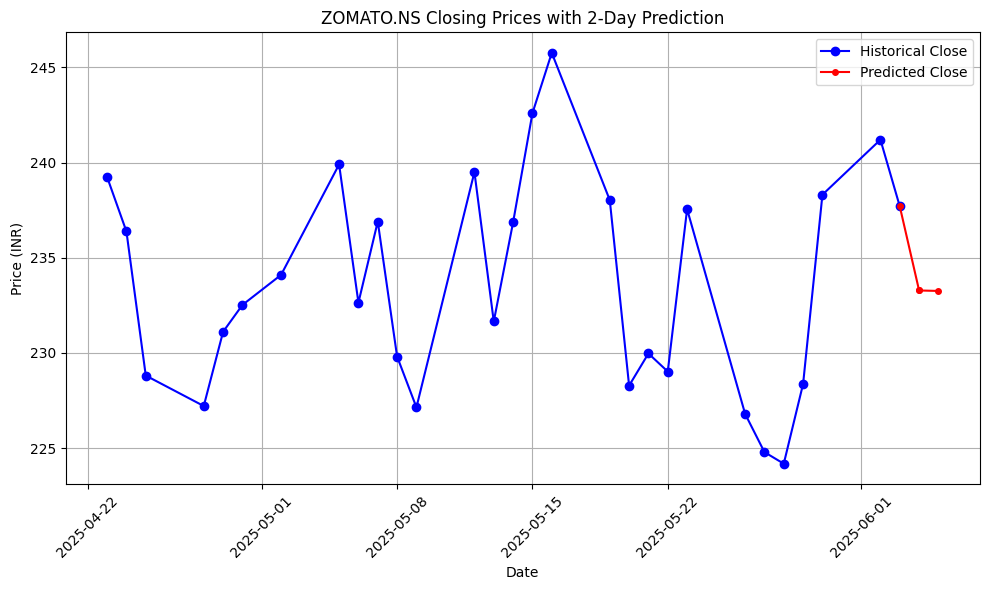


Step 7: Printing predictions...

Predicted Prices for ZOMATO.NS:
                  Open        High         Low       Close
Date                                                      
2025-06-04  232.709432  236.904311  229.176032  233.280341
2025-06-05  232.712245  236.855036  229.179170  233.254617


In [125]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import traceback # Import the traceback module

# Step 1: Load the CSV file, skipping initial metadata rows and skipping bad lines
# Based on previous observation, the first 2 rows are metadata in yfinance CSVs
try:
    print("Step 1: Loading and cleaning data...")
    try:
        df = pd.read_csv('/content/stock_data_colab/zometo_last_30_days.csv', skiprows=2, header=None,
                         names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], on_bad_lines='skip')


        # Convert the 'Date' column to datetime and set it as the index
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df.set_index('Date', inplace=True)
            df.dropna(inplace=True) # This will drop rows with NaT in index or NaN in any column

        else:
            print("❌ 'Date' column not found after renaming. Cannot set index.")
            df = pd.DataFrame() # Set df to empty to trigger the empty check later

        # If df is not empty after handling Date column and setting index
        if not df.empty:
            # Convert price and volume columns to numeric, coercing errors
            # Identify potential numeric columns based on the new column names
            potential_numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
            numeric_cols = [col for col in potential_numeric_cols if col in df.columns]

            for col in numeric_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].isnull().any():
                     print(f"Warning: NaN values introduced in column '{col}' after converting to numeric.")


            # Drop rows with NaN in essential columns after coercion (assuming Open, High, Low, Close are essential for prediction)
            essential_cols = ['Open', 'High', 'Low', 'Close']
            # Filter essential_cols to only include columns that exist in the DataFrame
            existing_essential_cols = [col for col in essential_cols if col in df.columns]
            if existing_essential_cols: # Only dropna if there are essential columns to check
                 df.dropna(subset=existing_essential_cols, inplace=True)
            else:
                 print("Warning: No essential columns found for dropping rows with NaN.")


        print("\n--- DataFrame after cleaning and setting index ---")
        print(df.columns)
        print(df.head())
        print("----------------------------------------------------")


    except Exception as e:
        print(f"❌ Error during Step 1: Data Loading and Cleaning: {e}")
        traceback.print_exc() # Print the full traceback
        df = pd.DataFrame() # Ensure df is defined even if loading fails


    # Step 2: Prepare features (use day number as the feature for simplicity)
    print("\nStep 2: Preparing features...")
    # Ensure df is not empty after cleaning
    if not df.empty:
        # Reset index to use 'Day' as a numerical feature
        df_reset = df.reset_index()
        df_reset['Day'] = np.arange(len(df_reset))


        # Step 3: Train linear regression models for Open, High, Low, Close
        print("\nStep 3: Training models...")
        models = {}
        predictions = {}
        # Use only the columns that exist in the DataFrame for prediction targets
        price_columns = [col for col in ['Open', 'High', 'Low', 'Close'] if col in df_reset.columns]


        for column in price_columns:
            try:
                # Check if the column exists and has numeric data
                if column in df_reset.columns and pd.api.types.is_numeric_dtype(df_reset[column]):
                    X = df_reset[['Day']].values
                    y = df_reset[column].values

                    # Ensure there's enough data to train the model (at least 2 data points for Linear Regression)
                    if len(X) > 1:
                        model = LinearRegression()
                        model.fit(X, y)
                        models[column] = model

                        # Predict for the next two days
                        future_days = np.array([[len(df_reset)], [len(df_reset) + 1]])
                        pred = model.predict(future_days)
                        predictions[column] = pred
                    else:
                         print(f"⚠️ Not enough data in '{column}' column to train the model.")
                         predictions[column] = [np.nan, np.nan] # Add NaN predictions if not enough data
                else:
                    print(f"⚠️ Column '{column}' not found or is not numeric after cleaning, skipping prediction for this column.")
                    predictions[column] = [np.nan, np.nan] # Add NaN predictions if column is missing or not numeric

            except Exception as e:
                print(f"❌ Error training model or predicting for column '{column}': {e}")
                traceback.print_exc() # Print the full traceback
                predictions[column] = [np.nan, np.nan] # Add NaN predictions on error


        # Step 4: Create a DataFrame for predictions
        print("\nStep 4: Creating predictions DataFrame...")
        # Check if predictions were made for all required columns (even if they are NaN)
        # Also ensure there's historical data to base future dates on
        if all(col in predictions for col in ['Open', 'High', 'Low', 'Close']) and not df.empty:
            # Calculate future dates based on the last date in the historical data (from the original df)
            last_historical_date = df.index[-1]
            future_dates = [last_historical_date + timedelta(days=i) for i in range(1, 3)] # Predict next 2 days

            # Create prediction DataFrame using available predictions
            pred_data = {'Date': future_dates}
            for col in ['Open', 'High', 'Low', 'Close']:
                pred_data[col] = predictions.get(col, [np.nan, np.nan])

            pred_df = pd.DataFrame(pred_data)
            pred_df.set_index('Date', inplace=True)

            # Step 5: Combine historical and predicted data for plotting
            print("\nStep 5: Combining data for plotting...")
            # Ensure 'Close' column exists in historical df and prediction df before plotting
            if 'Close' in df.columns and 'Close' in pred_df.columns:
                 # Select only the 'Close' column from the historical data for combining
                 combined_df = pd.concat([df[['Close']], pred_df[['Close']]])

                 # Step 6: Plot the historical and predicted closing prices
                 print("\nStep 6: Plotting results...")
                 plt.figure(figsize=(10, 6))
                 # Plot historical data
                 plt.plot(df.index, df['Close'], label='Historical Close', color='blue', marker='o')

                 # Plot the segment connecting last historical point to first predicted point
                 # Ensure there is at least one historical and one predicted point
                 if not df.empty and not pred_df.empty:
                     last_hist_date = df.index[-1]
                     last_hist_close = df['Close'].iloc[-1]
                     first_pred_date = pred_df.index[0]
                     first_pred_close = pred_df['Close'].iloc[0]
                     # Plot the connecting line as a solid red line with a dot marker at the predicted point
                     plt.plot([last_hist_date, first_pred_date], [last_hist_close, first_pred_close], color='red', linestyle='-', marker='.', markersize=8)


                 # Plot predicted data starting from the first predicted point as a solid red line with dot markers
                 # Start plotting from the first predicted point's index and value
                 plt.plot(pred_df.index, pred_df['Close'], label='Predicted Close', color='red', linestyle='-', marker='.', markersize=8)


                 plt.title('ZOMATO.NS Closing Prices with 2-Day Prediction')
                 plt.xlabel('Date')
                 plt.ylabel('Price (INR)')
                 plt.legend()
                 plt.grid(True)
                 plt.xticks(rotation=45)
                 plt.tight_layout()

                 # Display the plot in Colab
                 plt.show()
            else:
                 print("⚠️ Historical or predicted 'Close' column not available for plotting.")


            # Step 7: Print the predictions
            print("\nStep 7: Printing predictions...")
            print("\nPredicted Prices for ZOMATO.NS:")
            print(pred_df[['Open', 'High', 'Low', 'Close']])

        else:
             print("❌ Predictions could not be generated for all required price columns.")

    else:
        print("⚠️ DataFrame is empty after cleaning, cannot proceed with prediction.")

except FileNotFoundError:
    print("Error: zometo_last_30_days.csv not found. Please ensure the file exists in /content/stock_data_colab/")
except Exception as e:
    print(f"❌ An unexpected error occurred during processing: {e}")
    traceback.print_exc() # Print the full traceback